In [9]:
from scipy.optimize import ridder
import torch
import matplotlib.pyplot as plt
from MINE import MINE
from tqdm import tqdm
from torch.autograd import Variable
import numpy as np

import random
import os
def seed_torch(seed=1291):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True
seed_torch()

model = MINE(120, 4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [10]:
#生成联合高斯x,y dim
dim = 124
sep = 120
mutu = 0.5
cov = [[1,.5,.5,.5,.5],
       [.5,1,.5,.5,.5],
       [.5,.5,1,.5,.5],
       [.5,.5,.5,1,.5],
       [.5,.5,.5,.5,1]]
cov_p = [[1,.5,.5,0,0],
         [.5,1,.5,0,0],
         [.5,.5,1,0,0],
         [0,0,0,1,.5],
         [0,0,0,.5,1]]
cov = np.identity(dim)*(1-mutu) + np.ones((dim,dim))*mutu
cov_p = np.identity(dim)*(1-mutu) + np.ones((dim,dim))*mutu
for i in range(dim):
       for j in range(dim):
              if not ((i<sep and j<sep) or (i>=sep and j>=sep)):
                     cov_p[i,j] = 0
cov

array([[1. , 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 1. , 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 1. , ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 1. , 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 1. , 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 1. ]])

In [11]:

gaussian_xy = np.random.multivariate_normal(np.zeros(dim),cov,50000)
x = gaussian_xy[:,0:sep]
y = gaussian_xy[:,sep:dim]
y_shuffled = np.random.permutation(y)

x = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=False)#训练数据都是计算图里的叶节点，不需要梯度
y = Variable(torch.from_numpy(y).type(torch.FloatTensor), requires_grad=False)
y_shuffled = Variable(torch.from_numpy(y_shuffled).type(torch.FloatTensor), requires_grad=False)

In [12]:
skl = []
num_epoch = 1000
for epoch in tqdm(range(num_epoch)):
    '''
    index = np.random.choice(np.arange(x.shape[0]),size=10000,replace=False)
    x = gaussian_xy[:,0:sep][index]
    y = gaussian_xy[:,sep:dim][index]
    y_shuffled = np.random.permutation(y)
    '''
    ################################
    gaussian_xy = np.random.multivariate_normal(np.zeros(dim),cov,15000)
    x = gaussian_xy[:,0:sep]
    y = gaussian_xy[:,sep:dim]
    y_shuffled = np.random.permutation(y)
    ################################
    x = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=False)#训练数据都是计算图里的叶节点，不需要梯度
    y = Variable(torch.from_numpy(y).type(torch.FloatTensor), requires_grad=False)
    y_shuffled = Variable(torch.from_numpy(y_shuffled).type(torch.FloatTensor), requires_grad=False)
    
    pred_xy = model(x, y)
    pred_x_y = model(x, y_shuffled)

    loss1 = - torch.mean(pred_xy)
    loss2 = torch.mean(torch.exp(pred_x_y-1))
    '''
    plot_loss.append(loss1.data.numpy())
    print(loss1.item())
    '''
    loss = loss1 + loss2
    skl.append((-loss1-loss2).data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()


100%|██████████| 1000/1000 [02:46<00:00,  6.01it/s]


array(0.74973965, dtype=float32)

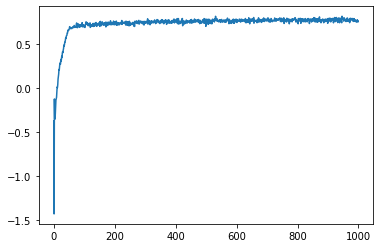

In [13]:
plot_x = np.arange(len(skl))
plot_y = np.array(skl)
plt.plot(plot_x, plot_y)
skl[len(skl)-1]

In [14]:
np.mean(skl[900:])

0.77056587

In [15]:
cov = np.array(cov)
cov_p = np.array(cov_p)
res = 0.5*(np.log(np.linalg.det(cov_p))-np.log(np.linalg.det(cov))+(np.linalg.inv(cov_p).dot(cov)-np.identity(dim)).trace())
res

0.7884573603643328

In [16]:
model

MINE(
  (fc1): Linear(in_features=120, out_features=200, bias=True)
  (fc2): Linear(in_features=4, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)